In [1]:
import torch 
import time
from utils.utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts
from DL_class import MultiModelTrainer, Trainer
from constants.config import get_args
from plotting import plot_k_fold_split
from utils.save_results import update_results_df
from constants.paths import FOLDER_PATH,FILE_NAME

import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

# Load config
model_name = 'STGCN' #'CNN'
args = get_args(model_name)

# Modification : 
args.epochs = 50
args.K_fold = 6
args.batch_size = 256
args.ray = False
args.track_pi = False # Sinon 30% du temps consommé pour track le PI.
# Memory format: Channel last
args.memory_format_last = True
# ...

# Mixed Precision:
args.mixed_precision = False
# ...

# Torch Compile:
args.torch_compile = False
# ...

# x.to('cuda', non_blocking = True)
args.non_blocking = False
# ...


# DataLoader and Num workers
args.num_workers = 0
args.persistent_workers = False
args.pin_memory = False
args.prefetch_factor = None
args.drop_last = False

# Prefetch data:
args.prefetch_all = False
# ...

def complete_train(args,FOLDER_PATH,FILE_NAME):
    # Load Multi-DataSet,k_fold split:
    t0 = time.time()
    dataset,invalid_dates = get_DataSet_and_invalid_dates(args.W,args.D,args.H,args.step_ahead,single_station = False)
    print(f"Time to compute 'get_DataSet_and_invalid_dates': {time.time()-t0}")

    t0 = time.time()
    (Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args,invalid_dates)
    print(f"Time to compute 'split_K_fold': {time.time()-t0}")

    t0 = time.time()
    (loss_function,Model_list,Optimizer_list,Scheduler_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding_list,dic_class2rpz_list,num_nodes = len(Datasets[0].spatial_unit))
    print(f"Time to compute 'get_MultiModel_loss_args_emb_opts': {time.time()-t0}")

    # Get First dataset, dataloader etc:
    model = Model_list[0].to(args.device)
    data_loader = DataLoader_list[0]
    optimizer = Optimizer_list[0]
    dic_class2rpz = dic_class2rpz_list[0]
    
    t1 = time.time()
    if args.torch_compile:
        model = torch.compile(model,backend=args.backend)
    trainer = Trainer(Datasets[0],model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)
    trainer.train_and_valid(mod = None, mod_plot = None,station = 0)
    print('torch training: ',time.time()-t1)
    pd.DataFrame({'valid': trainer.valid_loss}).plot()
    
    return(trainer)
    
    

'pynvml' is not available on this environment.


# Test sur STGCN 
## Sans optimisation :

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.2983522415161133
Time to compute 'split_K_fold': 8.12904691696167
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.0641016960144043
start training


/Users/romainrochas/opt/anaconda3/envs/tuning/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training Throughput:446.13 sequences per seconds
>>> Training complete in: 0:14:56.041715
>>> Training performance time: min 0.8237509727478027 avg 1.125020980834961 seconds (+/- 0.10251725858993857)
>>> Loading performance time: min 0.0038039684295654297 avg 0.6222409023105769 seconds (+/- 0.6245431360160132)
>>> Forward performance time: 0.3039434443898126 seconds (+/- 0.029687038380065738)
>>> Backward performance time: 0.8232177559057189 seconds (+/- 0.08038232838625799)
>>> Plotting performance time: 9.73137057557398e-07 seconds (+/- 4.1669133373195576e-07)
>>> Saving performance time: 0.0026402187347412107 seconds (+/- 0.002069103537901759)
>>> PI-tracking performance time: 1.6932584801498724e-06 seconds (+/- 6.76487758848213e-07)
>>> Scheduler-update performance time: 1.464571271623884e-06 seconds (+/- 5.678903034936723e-07)
Proportion of time consumed for Loading: 36.3%
Proportion of time consumed for Forward: 17.2%
Proportion of time consumed for Backward: 46.5%
Proportion of 

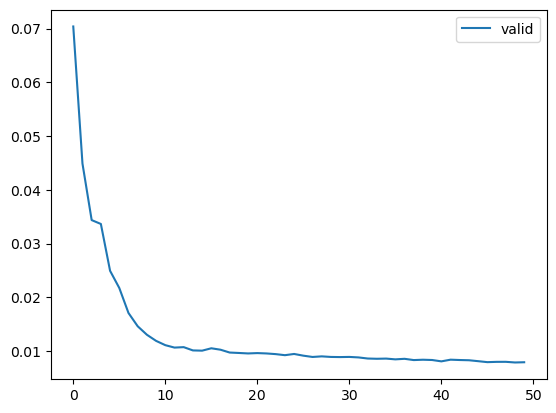

In [2]:
args.num_workers = 0
args.persistent_workers = False
args.pin_memory = False
args.prefetch_factor = None

args.autocast = False

args.non_blocking = False
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.20411300659179688
Time to compute 'split_K_fold': 8.444950819015503
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.06524991989135742
start training


/Users/romainrochas/opt/anaconda3/envs/tuning/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


'pynvml' is not available on this environment.
'pynvml' is not available on this environment.
Training Throughput:428.20 sequences per seconds
>>> Training complete in: 0:15:41.834933
>>> Training performance time: min 0.8160061836242676 avg 1.1357371807098389 seconds (+/- 0.20687874434930925)
>>> Loading performance time: min 0.001096963882446289 avg 0.6500492145343381 seconds (+/- 0.7016189942696174)
>>> Forward performance time: 0.31823191315319405 seconds (+/- 0.07416122075948739)
>>> Backward performance time: 0.8564060112949093 seconds (+/- 0.13770354099285462)
>>> Plotting performance time: 8.806890370894451e-07 seconds (+/- 3.129206908637363e-07)
>>> Saving performance time: 0.004351897239685059 seconds (+/- 0.007508723383678673)
>>> PI-tracking performance time: 1.415914418746014e-06 seconds (+/- 5.174582528540717e-07)
>>> Scheduler-update performance time: 1.2261526925223215e-06 seconds (+/- 4.30826140835405e-07)
Proportion of time consumed for Loading: 36.7%
Proportion of ti

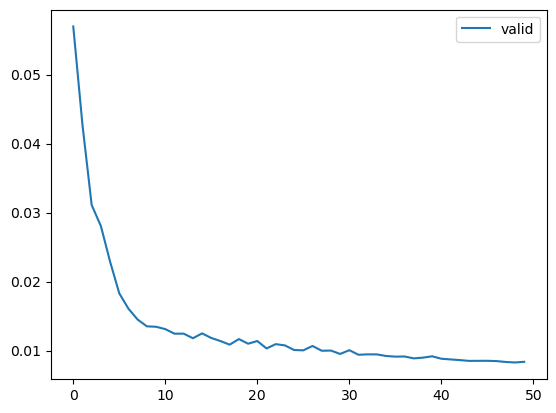

In [3]:
args.num_workers = 1
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 4

args.autocast = True

args.non_blocking = True

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

In [4]:
args.torch_compile = True
trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.31688594818115234
Time to compute 'split_K_fold': 8.321782112121582
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.06397175788879395


RuntimeError: Python 3.11+ not yet supported for torch.compile

## Après optimisation 

### Utilisation de num-workers = 1: 
Peu d'amélioration notable 

In [ ]:
args.num_workers = 1
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 2

args.autocast = False
args.non_blocking = False
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

## Utilisation de prefetch_factor > 2:

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.19359707832336426
Time to compute 'split_K_fold': 8.354772329330444
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.06240224838256836
start training
Training Throughput:11565.08 sequences per seconds
>>> Training complete in: 0:00:46.633076
>>> Training performance time: min 0.0343775749206543 avg 0.04351449012756348 seconds (+/- 0.0025828503695435046)
>>> Loading performance time: min 0.00016880035400390625 avg

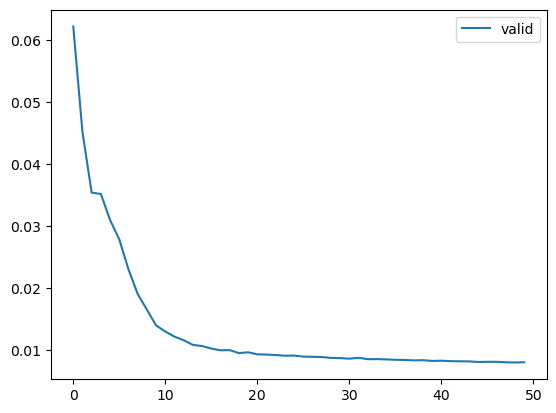

In [4]:
args.num_workers = 1
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 8

args.autocast = False
args.non_blocking = False
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.3553652763366699
Time to compute 'split_K_fold': 8.430397033691406
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.062050819396972656
start training
Training Throughput:11774.11 sequences per seconds
>>> Training complete in: 0:00:45.355798
>>> Training performance time: min 0.03458738327026367 avg 0.04241442680358887 seconds (+/- 0.002542691249428967)
>>> Loading performance time: min 0.0001480579376220703 avg 

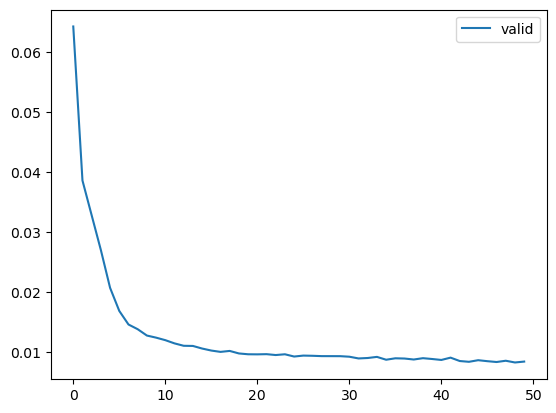

In [5]:
args.num_workers = 6
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 8

args.autocast = False
args.non_blocking = False
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.19501924514770508
Time to compute 'split_K_fold': 8.655198097229004
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.06438684463500977
start training
Training Throughput:11541.47 sequences per seconds
>>> Training complete in: 0:00:47.932133
>>> Training performance time: min 0.0347445011138916 avg 0.04350090026855469 seconds (+/- 0.00292614589277309)
>>> Loading performance time: min 0.00010371208190917969 avg 0

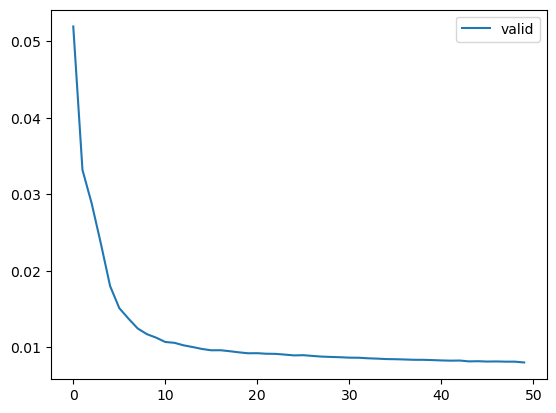

In [6]:
args.num_workers = 6
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 8

args.autocast = True
args.non_blocking = True
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

### Utilisation de Mixed-precision avec autocast()
Peu d'amélioration notable 

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.17840862274169922
Time to compute 'split_K_fold': 8.908262014389038
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.0683145523071289
start training
Training Throughput:11213.887322096887 sequences per seconds
>>> Training complete in: 0:00:49.219602
>>> Training performance time: min 0.034957170486450195 avg 0.04485726356506348 seconds (+/- 0.0027549648456789903)
>>> Loading performance time: min 0.0031397342681

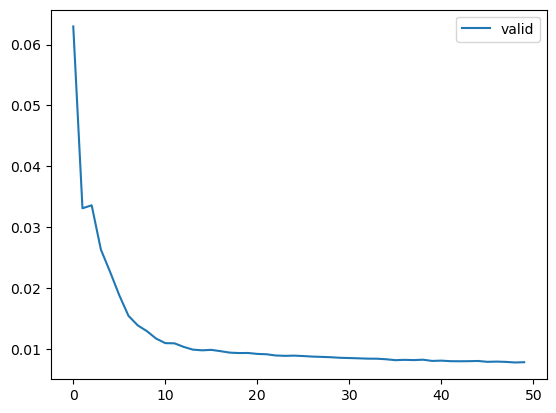

In [10]:
args.num_workers = 0
args.persistent_workers = 0
args.pin_memory = 0
args.prefetch_factor = None

args.autocast = True
args.non_blocking = False
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

## Utilisation de Non-Blocking: 

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.163374662399292
Time to compute 'split_K_fold': 8.111580848693848
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.060918331146240234
start training
Training Throughput:11399.575958137226 sequences per seconds
>>> Training complete in: 0:00:48.609475
>>> Training performance time: min 0.03507256507873535 avg 0.043331146240234375 seconds (+/- 0.0029338066823931365)
>>> Loading performance time: min 0.0031259059906

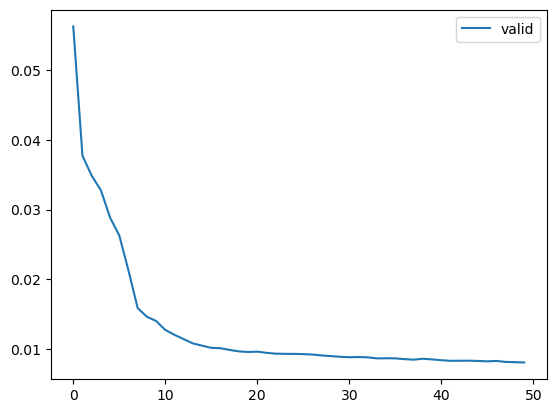

In [11]:
args.num_workers = 0
args.persistent_workers = 0
args.pin_memory = 0
args.prefetch_factor = None

args.autocast = False
args.non_blocking = True
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

## Utilisation des 3: 
Toujours d'aucune utilité

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.16352200508117676
Time to compute 'split_K_fold': 8.194646120071411
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
number of total parameters: 273358
number of trainable parameters: 273358
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.060808420181274414
start training
Training Throughput:11671.418500841499 sequences per seconds
>>> Training complete in: 0:00:44.978472
>>> Training performance time: min 0.030539751052856445 avg 0.04335308074951172 seconds (+/- 0.0029431256941643918)
>>> Loading performance time: min 0.00013041496

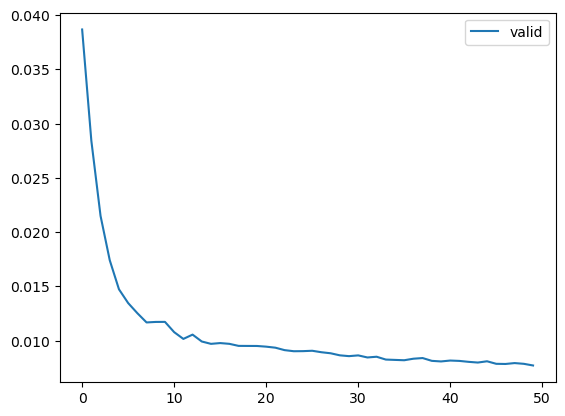

In [12]:
args.num_workers = 1
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 2

args.autocast = True
args.non_blocking = True
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

In [ ]:
args.num_workers = 2
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 3

args.autocast = True
args.non_blocking = True
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.1846606731414795
Time to compute 'split_K_fold': 8.191544532775879
Time to compute 'get_MultiModel_loss_args_emb_opts': 0.06245303153991699
start training


In [ ]:
args.num_workers = 6
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 3

args.autocast = True
args.non_blocking = True
args.torch_compile = False

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

## Utilisation de Torch.compile: 
Inutile + explosions de la consommation Memoire GPU pour bakcend = 'cudagraphs'

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.26770448684692383
Time to compute 'split_K_fold': 7.876119613647461
Time to compute 'get_MultiModel_loss_args_emb_opts': 1.544926404953003
start training


[2024-06-17 19:22:25,028] torch._dynamo.convert_frame: [ERROR] WON'T CONVERT forward /home/rrochas/uncertainty_quantification/dl_models/full_model.py line 21 
due to: 
Traceback (most recent call last):
  File "/root/anaconda3/envs/pytorch-2.0.1_py-3.10.5/lib/python3.10/site-packages/torch/utils/cpp_extension.py", line 25, in <module>
    from pkg_resources import packaging  # type: ignore[attr-defined]
ImportError: cannot import name 'packaging' from 'pkg_resources' (/root/anaconda3/envs/pytorch-2.0.1_py-3.10.5/lib/python3.10/site-packages/pkg_resources/__init__.py)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/root/anaconda3/envs/pytorch-2.0.1_py-3.10.5/lib/python3.10/site-packages/torch/_dynamo/output_graph.py", line 675, in call_user_compiler
    raise BackendCompilerFailed(self.compiler_fn, e) from e
torch._dynamo.exc.BackendCompilerFailed: debug_wrapper raised ImportError: cannot import name 'packaging' from 'pk


Max GPU memory allocated: 3.085141181945801 GB
Max GPU memory cached: 4.84375 GB
Max CPU memory allocated: 4.167446136474609 GB
None
torch training:  88.41666531562805


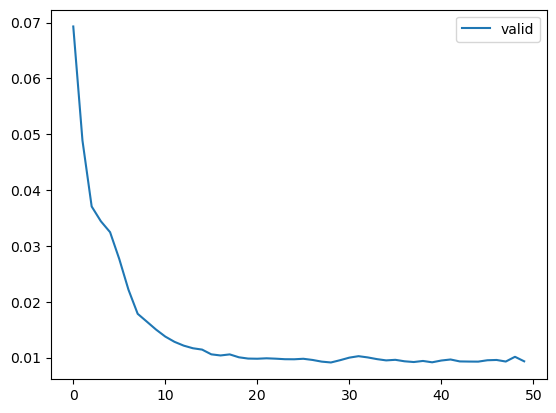

In [4]:
import torch._dynamo as torchdynamo
torchdynamo.config.suppress_errors = True
torchdynamo.reset()

args.num_workers = 1
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 2

args.autocast = True
args.torch_compile = True
args.backend = 'inductor'

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
Time to compute 'get_DataSet_and_invalid_dates': 0.1690845489501953
Time to compute 'split_K_fold': 7.8700408935546875
Time to compute 'get_MultiModel_loss_args_emb_opts': 1.5556645393371582
start training


/root/anaconda3/envs/pytorch-2.0.1_py-3.10.5/lib/python3.10/site-packages/torch/_functorch/aot_autograd.py:1253: UserWarning: Your compiler for AOTAutograd is returning a a function that doesn't take boxed arguments. Please wrap it with functorch.compile.make_boxed_func or handle the boxed arguments yourself. See https://github.com/pytorch/pytorch/pull/83137#issuecomment-1211320670 for rationale.
  warnings.warn(
/root/anaconda3/envs/pytorch-2.0.1_py-3.10.5/lib/python3.10/site-packages/torch/_functorch/aot_autograd.py:1253: UserWarning: Your compiler for AOTAutograd is returning a a function that doesn't take boxed arguments. Please wrap it with functorch.compile.make_boxed_func or handle the boxed arguments yourself. See https://github.com/pytorch/pytorch/pull/83137#issuecomment-1211320670 for rationale.
  warnings.warn(
/root/anaconda3/envs/pytorch-2.0.1_py-3.10.5/lib/python3.10/site-packages/torch/_functorch/aot_autograd.py:1253: UserWarning: Your compiler for AOTAutograd is returni


Max GPU memory allocated: 31.74046754837036 GB
Max GPU memory cached: 42.619140625 GB
Max CPU memory allocated: 4.212139129638672 GB
None
torch training:  116.21545314788818


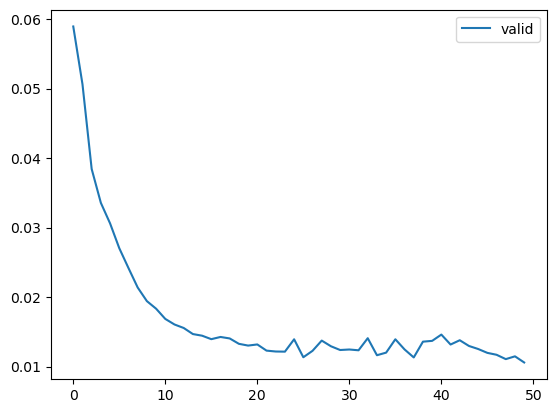

In [2]:
args.num_workers = 1
args.persistent_workers = True
args.pin_memory = True
args.prefetch_factor = 2

args.autocast = True
args.torch_compile = True
args.backend = 'cudagraphs'

trainer = complete_train(args,FOLDER_PATH,FILE_NAME)

# Test sur CNN
## Test sur 'memory_format = torch.channels_last': 
Pas/peu concluant. 

### Batch_size = 32

start training

Max GPU memory allocated: 0.2725052833557129 GB
Max GPU memory cached: 0.3203125 GB
Max CPU memory allocated: 4.090812683105469 GB
None
torch training:  69.90467357635498


<Axes: >

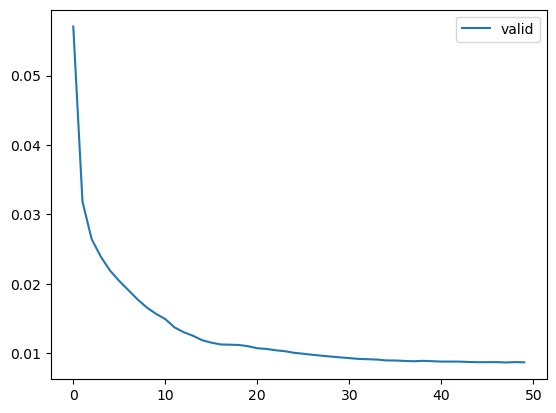

In [2]:
t1 = time.time()
trainer = Trainer(Datasets[0],model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)
trainer.train_and_valid(mod = None, mod_plot = None,station = 0)
print('torch training: ',time.time()-t1)
pd.DataFrame({'valid': trainer.valid_loss}).plot()

### Batch-size = 256

start training

Max GPU memory allocated: 0.2725052833557129 GB
Max GPU memory cached: 0.3203125 GB
Max CPU memory allocated: 4.396026611328125 GB
None
torch training:  27.118371963500977


<Axes: >

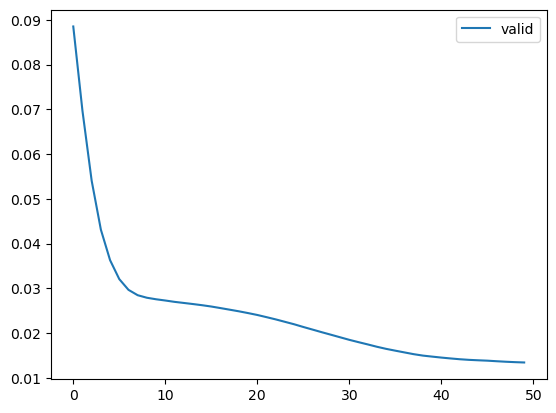

In [4]:
t1 = time.time()
trainer = Trainer(Datasets[0],model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)
trainer.train_and_valid(mod = None, mod_plot = None,station = 0)
print('torch training: ',time.time()-t1)
pd.DataFrame({'valid': trainer.valid_loss}).plot()

<Axes: >

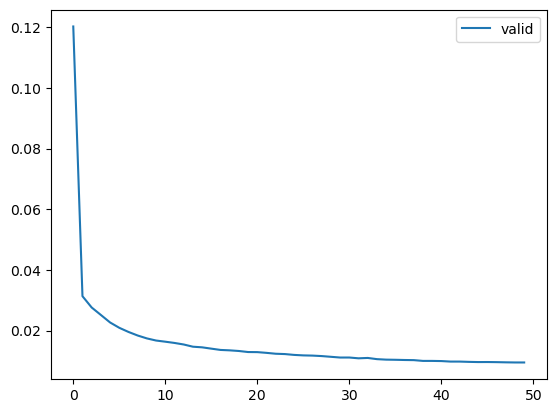

In [7]:
5760/40

144.0